In [30]:
import sys
sys.path.append('../..')
sys.path.append('../../APDFT')
sys.path.append('../../helper_code')
sys.path.append('../data')

import pickle
from pyscf import gto, scf, dft, cc
from ase import Atoms
import numpy as np
import pandas as pd
import pyscf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import basis_set_exchange as bse
from APDFT.FcMole import *
import os
import ast
from copy import deepcopy
from IPython.display import display
from helper_code.data_processing import *


%load_ext autoreload
%autoreload 2
from APDFT.AP_class import APDFT_perturbator as AP

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Dataset ##

In [2]:
coronene_energy_raw_data = np.load("../data/coronene_raw_data/coronene_mutants_pbe0_pcx2.npz", allow_pickle=True)
charges, total_energy = coronene_energy_raw_data['charges'], coronene_energy_raw_data['energies']

columns = ['charges', 'total energy']
coronene_energy_data = pd.DataFrame(columns=columns)
coronene_energy_data['charges'] = charges.tolist()
coronene_energy_data['total energy'] = total_energy.tolist()

CORONENE_REF_ENERGY = -909.721935153841
coronene_energy_data['delta total energy'] = coronene_energy_data['total energy'].apply(lambda x: CORONENE_REF_ENERGY-x)

display(coronene_energy_data.head(3))

,charges,total energy,delta total energy
0,"[7, 5, 5, 5, 5, 7, 5, 7, 5, 5, 7, 7, 5, 7, 6, ...",-946.036986,36.315051
1,"[6, 5, 7, 6, 6, 6, 6, 6, 6, 6, 5, 7, 6, 5, 7, ...",-929.442623,19.720687
2,"[6, 5, 7, 5, 5, 5, 7, 5, 5, 6, 5, 7, 7, 5, 6, ...",-942.508112,32.786177


In [3]:
hessian_data = np.load("coronene_pbe0_pcX2_hessian.npz", allow_pickle=True)
H = hessian_data['H']
ANM_eigval, Q = np.linalg.eig(H)
Q_inv = np.linalg.inv(Q)

## Data Processing ##

In [31]:
rotation_mapping = {0:21, 21:22, 22:15, 15:12, 12:7, 7:0, 
                    1:20, 20:23, 23:14, 14:13, 13:6, 6:1,
                    2:19, 19:16, 16:11, 11:8, 8:5, 5:2,
                    3:18, 18:17, 17:10, 10:9, 9:4, 4:3}

reflection_mapping1 = {0:6, 6:0, 7:1, 1:7, 5:5, 
                       8:2, 2:8, 4:4, 13:21, 21:13,
                       9:3, 3:9, 12:20, 20:12, 10:18, 18:10,
                       11:19, 19:11, 17:17, 14:22, 22:14, 16:16,
                       15:23, 23:15}

reflection_mapping2 = {0:1, 1:0, 6:21, 21:6, 5:2, 2:5,
                       7:20, 20:7, 4:3, 3:4, 8:19, 19:8,
                       9:18, 18:9, 13:22, 22:13, 10:17, 17:10,
                       12:23, 23:12, 11:16, 16:11, 14:15, 15:14}



In [34]:
ref_charge = 6* np.ones((24,))

coronene_energy_data['dx'] = coronene_energy_data['charges'].apply(
    lambda arr: (np.array(arr[:24]) - ref_charge).astype(int).tolist())

coronene_energy_data['dx_lexi'] = coronene_energy_data['dx'].apply(
    lambda arr: coronene_lexi(arr, rotation_mapping, reflection_mapping1, reflection_mapping2))

coronene_energy_data['num_dope'] = coronene_energy_data['dx'].apply(
    lambda arr: sum(1 for elem in arr if elem != 0))

coronene_energy_data['c'] = coronene_energy_data['dx'].apply(
    lambda arr: (np.array(arr).reshape(1, 24) @ Q).reshape(24,).tolist()) # column vector view: c = Q_inv @ dx

coronene_energy_data['c_lexi'] = coronene_energy_data['dx_lexi'].apply(
    lambda arr: (arr.reshape(1, 24) @ Q).reshape(24,).tolist())

coronene_energy_data['c_lexi_nd'] = coronene_energy_data.apply(
    lambda row: [row['num_dope']/10] + row['c_lexi'], axis=1)

coronene_energy_data['CE'] = coronene_energy_data['c'].apply(
    lambda arr: compute_lambda_c(arr, ANM_eigval))

coronene_energy_data['CE_lexi'] = coronene_energy_data['c_lexi'].apply(
    lambda arr: compute_lambda_c(arr, ANM_eigval))

coronene_energy_data['CE_lexi_nd'] = coronene_energy_data.apply(
    lambda row: [row['num_dope']/10] + row['CE_lexi'], axis=1)

coronene_energy_data['CSE'] = coronene_energy_data['c'].apply(
    lambda arr: compute_lambda_c_square(arr, ANM_eigval))

coronene_energy_data['CSE_lexi'] = coronene_energy_data['c_lexi'].apply(
    lambda arr: compute_lambda_c_square(arr, ANM_eigval))

coronene_energy_data['CSE_lexi_nd'] = coronene_energy_data.apply(
    lambda row: [row['num_dope']/10] + row['CSE_lexi'], axis=1)

# print(coronene_energy_data['dx'][0])
# print(coronene_energy_data['dx_lexi'][0])
# print(coronene_energy_data['c_lexi'][0])
# print(coronene_energy_data['num_dope'][0])
# print(coronene_energy_data['c_lexi_nd'][0])
print(coronene_energy_data['CSE_lexi'][0])
# dx_vec = np.array(coronene_energy_data['dx_lexi'][0]).T
# c_vec = Q_inv @ dx_vec
# c_arr = c_vec.tolist()
# print(c_arr)

# display(coronene_energy_data.head(3))

[-0.0026917564303048573, 0.473052738593049, 0.2881488633267731, 0.05261198652352508, 0.02079772361829213, 1.1706339358114124, 0.3950493761843269, 4.317272512799243, 4.000051314316387, 0.012664235917368188, 2.6280037262423055, 0.1018444383554309, 0.2618853674057247, 0.11104066162926875, 0.7736099461179407, 1.159790598613749, 2.72085708256337, 4.459345165847076, 5.444428816023162e-06, 0.8242306284324226, 0.03276526966370406, 0.9364106599095192, 3.707707508105147, 2.290101613342301]


In [55]:
coronene_energy_data['second order alchemy'] = coronene_energy_data['CSE_lexi'].apply(lambda arr: sum(arr))
coronene_energy_data['delta delta total energy'] = coronene_energy_data['delta total energy'] - coronene_energy_data['second order alchemy']
# print(coronene_energy_data['delta total energy'].mean())
# print(coronene_energy_data['delta delta total energy'].mean())
# display(coronene_energy_data[['second order alchemy', 'delta total energy', 'delta delta total energy']])

## Export Data ##

In [35]:
datasets = ['c', 'c_lexi', 'c_lexi_nd', 'CE', 'CE_lexi', 'CE_lexi_nd', 
            'CSE', 'CSE_lexi', 'CSE_lexi_nd']
columns = [f"coord{i}" for i in range(24)]

dataset_dict = {}
for data in datasets:
    dataset_dict[data] = pd.DataFrame(columns=columns)
    for i in range(24):
        dataset_dict[data][f"coord{i}"] = coronene_energy_data[data].apply(lambda arr: arr[i])

# display(dataset_dict['CSE_lexi'])

In [36]:
for key, dataframe in dataset_dict.items():
    dataframe.to_csv(f'../data/coronene_training_data/{key}.csv', index=False)

In [56]:
coronene_energy_data['delta total energy'].to_csv('../data/coronene_training_data/delta_total_energy.csv', index=False)
coronene_energy_data['delta delta total energy'].to_csv('../data/coronene_training_data/delta_delta_total_energy.csv', index=False)

## dx Uniqueness ##

In [57]:
from scipy.spatial.distance import cdist

dx_matrix = np.vstack(coronene_energy_data['dx'].tolist())
dx_lexi_matrix = np.vstack(coronene_energy_data['dx_lexi'].tolist())

# Calculate pairwise Euclidean distances between rows
dist_matrix = cdist(dx_lexi_matrix, dx_lexi_matrix, metric='euclidean')
np.fill_diagonal(dist_matrix, None)

zero_count = 0
for i in range(dist_matrix.shape[0]):
    for j in range(dist_matrix.shape[1]):
        if dist_matrix[i][j] == 0:
            zero_count += 1
            print("Identity:")
            print("dx 1: ", dx_matrix[i])
            print("dx 2: ", dx_matrix[j])
            print("resulting lexi mapping 1: ", dx_lexi_matrix[i])
            print("resulting lexi mapping 2: ", dx_lexi_matrix[j])
            print("energy of dx 1:", coronene_energy_data['delta total energy'][i])
            print("energy of dx 2:", coronene_energy_data['delta total energy'][j])
            print("delta delta energy of dx1:", coronene_energy_data['delta delta total energy'][i])
            print("delta delta energy of dx2:", coronene_energy_data['delta delta total energy'][j])
            print()
print("zero count:", zero_count)

Identity:
dx 1:  [ 0  0  0  0  0 -1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
dx 2:  [ 0  0  0  0  0  0  0  0  0  0  0 -1  0  1  0  0  0  0  0  0  0  0  0  0]
resulting lexi mapping 1:  [ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
resulting lexi mapping 2:  [ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
energy of dx 1: 3.2716754514889317
energy of dx 2: 3.271681146053993
delta delta energy of dx1: 0.5609295307175071
delta delta energy of dx2: 0.5609352252825683

Identity:
dx 1:  [ 0  0  0  0  0 -1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
dx 2:  [ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  1  0  0  0  0  0  0  0  0]
resulting lexi mapping 1:  [ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
resulting lexi mapping 2:  [ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
energy of dx 1: 3.2716754514889317
energy of dx 2: 3.2716816168468768
delta delta energy o

In [50]:
target_array = [0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0]

mask = coronene_energy_data['dx_lexi'].apply(lambda arr: arr.tolist() == target_array)
# display(mask)
coronene_energy_data.loc[mask, ['dx', 'dx_lexi', 'total energy']]

,dx,dx_lexi,total energy
42,"[0, 0, 0, 0, 0, -1, 0, 1, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",-912.993611
186,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 1, 0,...","[0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",-912.993616
1304,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0,...","[0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",-912.993617
1880,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0,...","[0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",-912.993617
2241,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",-912.993604


## Feature Distribution ##

[ 2.20000000e+00 -1.16415601e-03 -1.03283839e+00 ... -1.96144872e-01
  3.16074214e-01  8.27182623e-01]


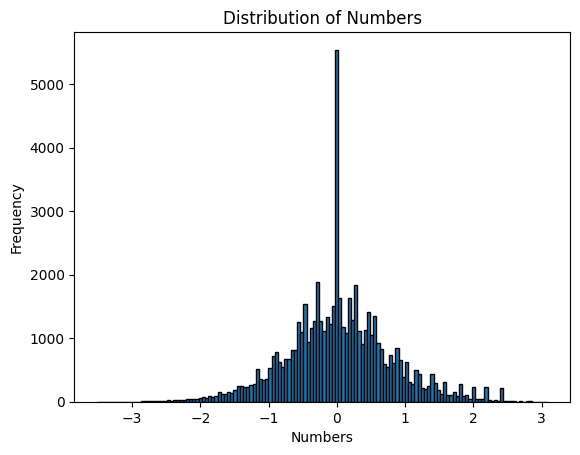

In [15]:
C = np.vstack(coronene_energy_data['c_lexi_nd'].tolist()).flatten()
print(C)
# Plot the histogram
plt.hist(C, bins='auto', edgecolor='black')
plt.xlabel('Numbers')
plt.ylabel('Frequency')
plt.title('Distribution of Numbers')

plt.show()

[ 2.20000000e+00 -3.67728801e-06  8.86895734e-01 ...  5.84328154e-02
  1.46301129e-01  1.00201119e+00]


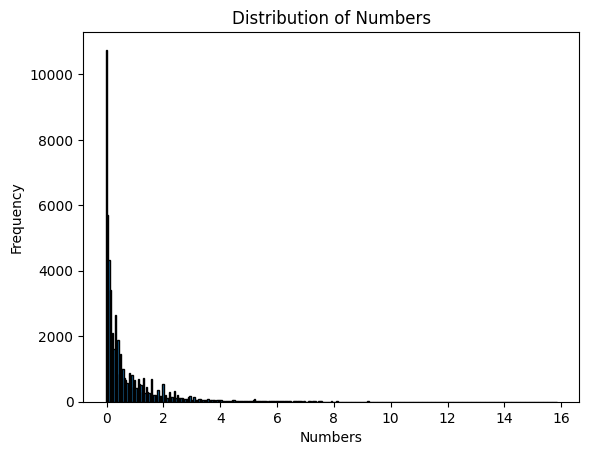

In [13]:
CSE = np.vstack(coronene_energy_data['CSE_lexi_nd'].tolist()).flatten()
print(CSE)
# Plot the histogram
plt.hist(CSE, bins='auto', edgecolor='black')
plt.xlabel('Numbers')
plt.ylabel('Frequency')
plt.title('Distribution of Numbers')

plt.show()

[ 2.2         0.00315876 -0.85869749 ... -0.29790641  0.46286955
  1.21135426]


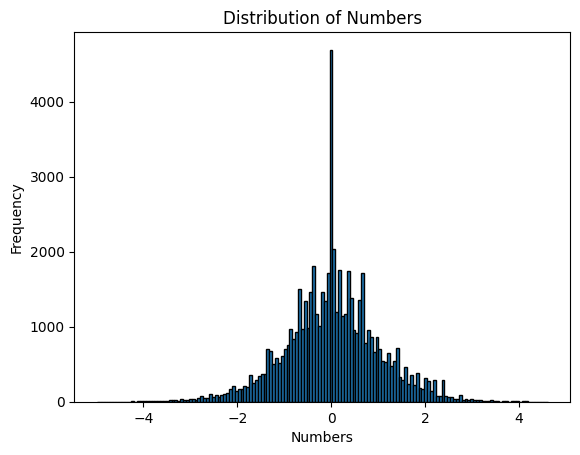

In [14]:
CE = np.vstack(coronene_energy_data['CE_lexi_nd'].tolist()).flatten()
print(CE)
# Plot the histogram
plt.hist(CE, bins='auto', edgecolor='black')
plt.xlabel('Numbers')
plt.ylabel('Frequency')
plt.title('Distribution of Numbers')

plt.show()

## Target Distribution ##

[5.51636722 3.32582915 6.99704056 ... 5.10960113 2.21484455 2.54989888]
mean: 4.260245676354518
minimum: 0.5798839771400259
maximum: 12.875830435434946
std: 2.462527263064554


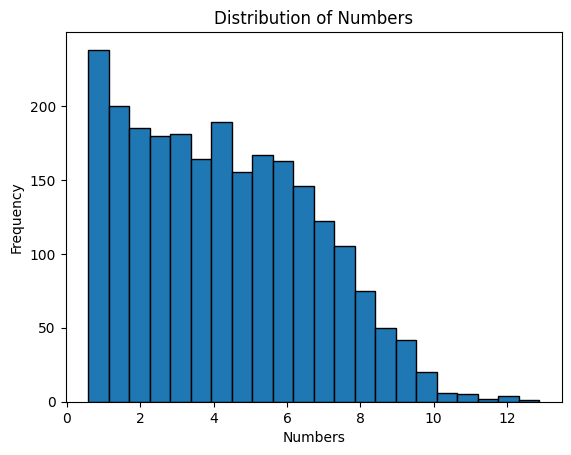

In [23]:
delta_delta = np.array(coronene_energy_data['delta delta total energy']).flatten()
print(delta_delta)
print("mean:", delta_delta.mean())
print("minimum:", delta_delta.min())
print("maximum:", delta_delta.max())
print("std:", delta_delta.std())
# Plot the histogram
plt.hist(delta_delta, bins='auto', edgecolor='black')
plt.xlabel('Numbers')
plt.ylabel('Frequency')
plt.title('Distribution of Numbers')

plt.show()